#### MF728 - Final Project
Author: Chi-Yuan Peng

# Package Import

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import time
import pandas_datareader.data as web
import datetime

import os

from scipy.optimize import minimize

from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from statsmodels.tsa.api import VAR
from scipy.stats import norm
from tqdm import tqdm
import cvxpy as cp

# Step 1. Data Integration

## US treasuries
soruce: https://home.treasury.gov/policy-issues/financing-the-government/interest-rate-statistics?data=yield

In [ ]:
ls_rates = ['daily_treasury_yield_curve','daily_treasury_bill_rates','daily_treasury_long_term_rate','daily_treasury_real_yield_curve','daily_treasury_real_long_term']
ls_years = ['2015','2016','2017','2018','2019','2020','2021','2022','2023','2024']

for rate in ls_rates:
    df_all = pd.DataFrame()
    for year in ls_years:
        html_head = f'https://home.treasury.gov/resource-center/data-chart-center/interest-rates/TextView?type={rate}&field_tdr_date_value={year}'
        df = pd.read_html(html_head)[0]
        if df_all.empty:
            df_all = df
        else:
            df_all = pd.concat([df_all, df])
    df_all.to_pickle(f'US treasuries(raw)/{rate}.pkl.zip', compression='zip')
    time.sleep(2)  # Sleep for 2 seconds between requests to avoid overwhelming the server

In [ ]:
path = "raw data/US treasuries/" 
df_all = pd.DataFrame()
for file in os.listdir(path):
    rate = file[:-8]
    print(path+file)
    df = pd.read_pickle(path+file)
    ls_missing = list(df.columns[df.isnull().sum() == df.shape[0]])
    df.drop(columns=ls_missing, inplace=True)
    df = pd.melt(df, id_vars=["Date"], var_name="maturity", value_name="rate")
    print(df['maturity'].unique())
    df['yield name'] = rate.replace("_", " ")
    if df_all.empty:
        df_all = df.copy()
    else:
        df_all = pd.concat([df_all, df], axis=0)

In [ ]:
df_all = df_all[["Date", "maturity", "yield name", "rate"]]
df_all.dropna(inplace=True)
dict_coupon_equivalent = {'COUPON EQUIVALENT': '4 WEEKS COUPON EQUIVALENT',
                            'COUPON EQUIVALENT.1': '6 WEEKS COUPON EQUIVALENT',
                            'COUPON EQUIVALENT.2': '8 WEEKS COUPON EQUIVALENT',
                            'COUPON EQUIVALENT.3': '13 WEEKS COUPON EQUIVALENT',
                            'COUPON EQUIVALENT.4': '17 WEEKS COUPON EQUIVALENT',
                            'COUPON EQUIVALENT.5': '26 WEEKS COUPON EQUIVALENT',
                            'COUPON EQUIVALENT.6': '52 WEEKS COUPON EQUIVALENT'}

df_all['maturity'] = df_all['maturity'].replace(dict_coupon_equivalent)
for i in df_all.groupby('yield name'):
    print(i[0])
    print(i[1].maturity.unique())
df_all1 = df_all.query("`yield name` != 'daily treasury long term rate'")
df_all1[[ 'yield name','maturity' ]].value_counts().to_frame()

df_all1.to_csv("yield_curve.csv", index=False)

## Macroeconomic

In [ ]:
start = datetime.datetime(2015, 1, 1)
end = datetime.datetime(2025, 1, 1)

df_macro = web.DataReader(['GDP','CPIAUCSL','UNRATE','PCE'], 'fred', start, end)
df_macro.fillna(method='ffill',inplace=True)
df_macro.to_csv('raw data/macroeconomics.csv', index = False) 

C:\Users\木木小呆猪\AppData\Local\Temp\ipykernel_25324\2742748137.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_macro.fillna(method='ffill',inplace=True)


# Step 2. Yield Curve Modeling and Forecasting

In [4]:
df = pd.read_csv("2 yield cuvre construction/yield curve data.csv") 
df['Date'] = pd.to_datetime(df['Date'])

df_wide = df.pivot(index = 'Date', columns = 'maturity', values = 'rate')
df_wide.head()

maturity,1 Mo,1 Yr,10 YR,10 Yr,13 WEEKS BANK DISCOUNT,13 WEEKS COUPON EQUIVALENT,17 WEEKS BANK DISCOUNT,17 WEEKS COUPON EQUIVALENT,2 Mo,2 Yr,...,52 WEEKS BANK DISCOUNT,52 WEEKS COUPON EQUIVALENT,6 Mo,7 YR,7 Yr,8 WEEKS BANK DISCOUNT,8 WEEKS COUPON EQUIVALENT,LT COMPOSITE (>10 Yrs),LT Real Average (10> Yrs),TREASURY 20-Yr CMT
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-02,0.02,0.25,0.41,2.12,0.02,0.02,NaN,NaN,NaN,0.66,...,0.22,0.22,0.11,0.37,1.92,NaN,NaN,2.48,0.64,2.41
2015-01-05,0.02,0.26,0.40,2.04,0.03,0.03,NaN,NaN,NaN,0.68,...,0.23,0.23,0.10,0.36,1.85,NaN,NaN,2.40,0.60,2.32
2015-01-06,0.02,0.25,0.41,1.97,0.03,0.03,NaN,NaN,NaN,0.65,...,0.25,0.25,0.10,0.36,1.78,NaN,NaN,2.32,0.58,2.25
2015-01-07,0.02,0.25,0.39,1.96,0.03,0.03,NaN,NaN,NaN,0.62,...,0.25,0.25,0.09,0.35,1.76,NaN,NaN,2.32,0.58,2.25
2015-01-08,0.01,0.23,0.41,2.03,0.03,0.03,NaN,NaN,NaN,0.62,...,0.23,0.23,0.08,0.38,1.81,NaN,NaN,2.39,0.63,2.33


In [5]:
df_wide.isnull().sum()

maturity
1 Mo                             0
1 Yr                             0
10 YR                            0
10 Yr                            0
13 WEEKS BANK DISCOUNT           0
13 WEEKS COUPON EQUIVALENT       0
17 WEEKS BANK DISCOUNT        1951
17 WEEKS COUPON EQUIVALENT    1951
2 Mo                           949
2 Yr                             0
20 YR                            0
20 Yr                            0
26 WEEKS BANK DISCOUNT           0
26 WEEKS COUPON EQUIVALENT       0
3 Mo                             0
3 Yr                             0
30 YR                            0
30 Yr                            0
4 Mo                          1951
4 WEEKS BANK DISCOUNT            0
4 WEEKS COUPON EQUIVALENT        0
5 YR                             0
5 Yr                             0
52 WEEKS BANK DISCOUNT           0
52 WEEKS COUPON EQUIVALENT       0
6 Mo                             0
7 YR                             0
7 Yr                             0
8 WEEKS BAN

In [6]:
maturity_map = {
    '4 WEEKS COUPON EQUIVALENT': 0.08,
    '8 WEEKS COUPON EQUIVALENT': 0.15,
    '13 WEEKS COUPON EQUIVALENT': 0.25,
    '26 WEEKS COUPON EQUIVALENT': 0.5,
    '52 WEEKS COUPON EQUIVALENT': 1.0,
    '2 Yr': 2.0,
    '3 Yr': 3.0,
    '5 Yr': 5.0,
    '7 Yr': 7.0,
    '10 Yr': 10.0,
    '20 Yr': 20.0,
    '30 Yr': 30.0
}

df_clean = df_wide.copy()

df_clean['8 WEEKS COUPON EQUIVALENT'] = df_clean['8 WEEKS COUPON EQUIVALENT'].interpolate(method = 'time').ffill().bfill()      # interpolate 0.15Y

df_curve = df_clean[maturity_map.keys()].copy()
df_curve.columns = [maturity_map[col] for col in df_curve.columns]

df_curve = df_curve[sorted(df_curve.columns)]
df_curve.head()

,0.08,0.15,0.25,0.50,1.00,2.00,3.00,5.00,7.00,10.00,20.00,30.00
Date,,,,,,,,,,,,
2015-01-02,0.02,2.21,0.02,0.11,0.22,0.66,1.07,1.61,1.92,2.12,2.41,2.69
2015-01-05,0.02,2.21,0.03,0.10,0.23,0.68,1.06,1.57,1.85,2.04,2.32,2.60
2015-01-06,0.02,2.21,0.03,0.10,0.25,0.65,1.02,1.50,1.78,1.97,2.25,2.52
2015-01-07,0.02,2.21,0.03,0.09,0.25,0.62,1.00,1.47,1.76,1.96,2.25,2.52
2015-01-08,0.01,2.21,0.03,0.08,0.23,0.62,1.00,1.50,1.81,2.03,2.33,2.59


In [7]:
# missing value check
df_curve.isnull().sum()

0.08     0
0.15     0
0.25     0
0.50     0
1.00     0
2.00     0
3.00     0
5.00     0
7.00     0
10.00    0
20.00    0
30.00    0
dtype: int64

  0%|          | 2/2501 [00:00<02:05, 19.89it/s]

100%|██████████| 2501/2501 [01:29<00:00, 27.92it/s]


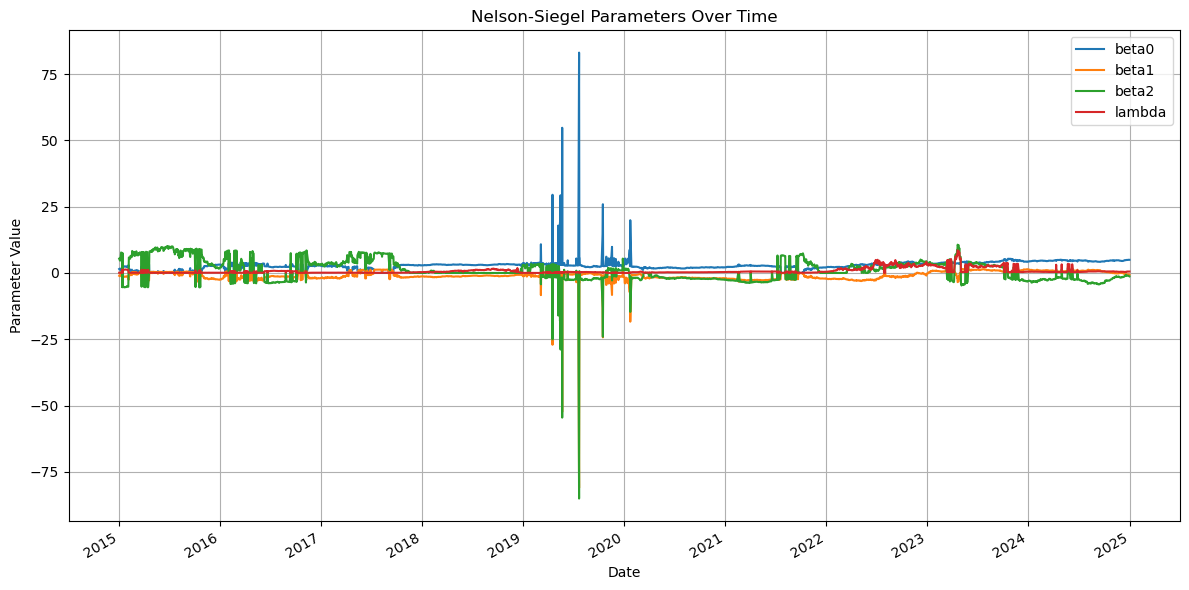

In [8]:
# Nelson-Siegel model
def nelson_siegel(tau, beta0, beta1, beta2, lamb):
    term1 = beta0
    term2 = beta1 * ((1 - np.exp(-lamb * tau)) / (lamb * tau))
    term3 = beta2 * (((1 - np.exp(-lamb * tau)) / (lamb * tau)) - np.exp(-lamb * tau))
    return term1 + term2 + term3

def fit_nelson_siegel(yields, tau):
    def objective(params):
        beta0, beta1, beta2, lamb = params
        fitted = nelson_siegel(tau, beta0, beta1, beta2, lamb)
        return np.sum((yields - fitted) ** 2)

    init = [0.03, -0.01, 0.01, 0.5]
    bounds = [(0, None), (None, None), (None, None), (0.01, 10)]
    result = minimize(objective, init, bounds = bounds, method = 'L-BFGS-B')
    
    return result.x if result.success else [np.nan] * 4

maturities = df_curve.columns.astype(float).values
beta_series = []
for idx, row in tqdm(df_curve.iterrows(), total = len(df_curve)):
    if row.isnull().any():
        beta_series.append([np.nan]*4)
        continue
    
    yields = row.values
    params = fit_nelson_siegel(yields, maturities)
    beta_series.append(params)

betas_df = pd.DataFrame(beta_series, columns = ['beta0', 'beta1', 'beta2', 'lambda'], index = df_curve.index)
betas_df.dropna(inplace = True)

betas_df.to_csv("results/nelson_siegel_parameters.csv")
betas_df.plot(title = "Nelson-Siegel Parameters Over Time", figsize = (12, 6), grid = True)
plt.ylabel("Parameter Value")
plt.tight_layout()
plt.show()

In [9]:
# clean the outliers, take -10 to 10 only
betas_df = betas_df.clip(lower = -10, upper = 10)

In [10]:
betas_df.head()

,beta0,beta1,beta2,lambda
Date,,,,
2015-01-02,1.482202,-1.064879,5.399647,0.082231
2015-01-05,1.680406,-1.251989,4.644588,0.086198
2015-01-06,1.406394,-0.970128,4.959815,0.079218
2015-01-07,1.096531,-0.662874,5.596283,0.072661
2015-01-08,0.660181,-0.240069,6.693806,0.068465


d:\Program Files\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\木木小呆猪\AppData\Local\Temp\ipykernel_10896\1831932923.py:11: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(betas_df.index[-1] + pd.DateOffset(months = 1), periods = forecast_steps, freq = 'M')


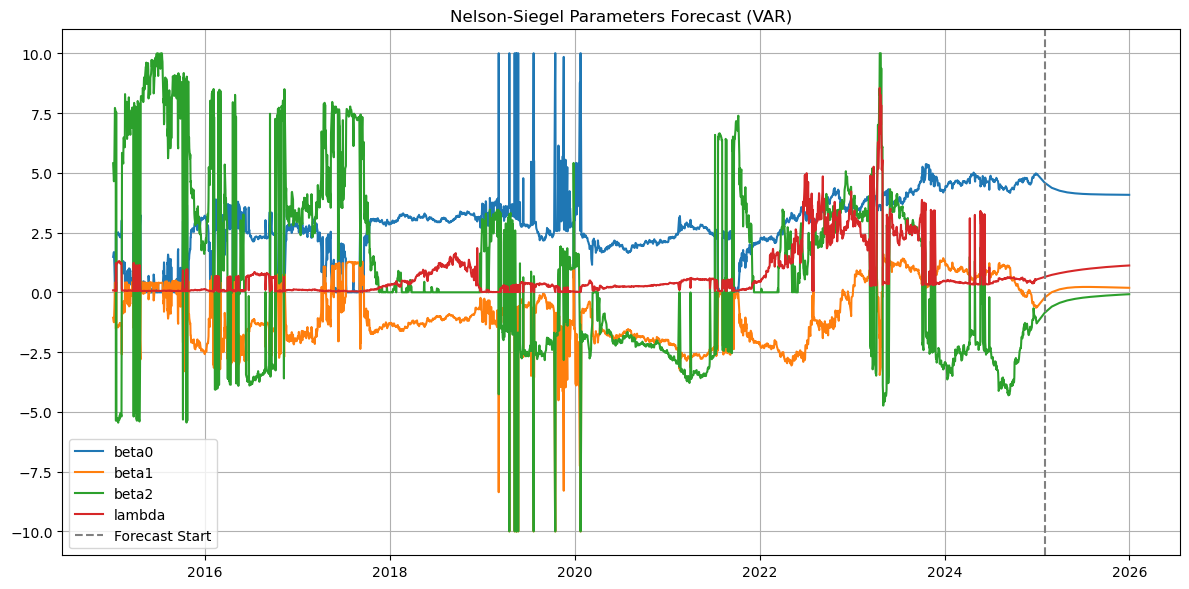

In [11]:
betas_df = betas_df.dropna()

# Fit VaR(1)
model = VAR(betas_df)
results = model.fit(maxlags = 1)

# Forecast next 12 steps (12 mo)
forecast_steps = 12
forecast = results.forecast(betas_df.values[-results.k_ar:], steps = forecast_steps)

forecast_index = pd.date_range(betas_df.index[-1] + pd.DateOffset(months = 1), periods = forecast_steps, freq = 'M')
forecast_df = pd.DataFrame(forecast, columns = betas_df.columns, index = forecast_index)

all_betas = pd.concat([betas_df, forecast_df])

plt.figure(figsize = (12, 6))
for col in betas_df.columns:
    plt.plot(all_betas[col], label = col)
plt.axvline(x = forecast_index[0], color = 'gray', linestyle = '--', label = 'Forecast Start')
plt.title("Nelson-Siegel Parameters Forecast (VAR)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

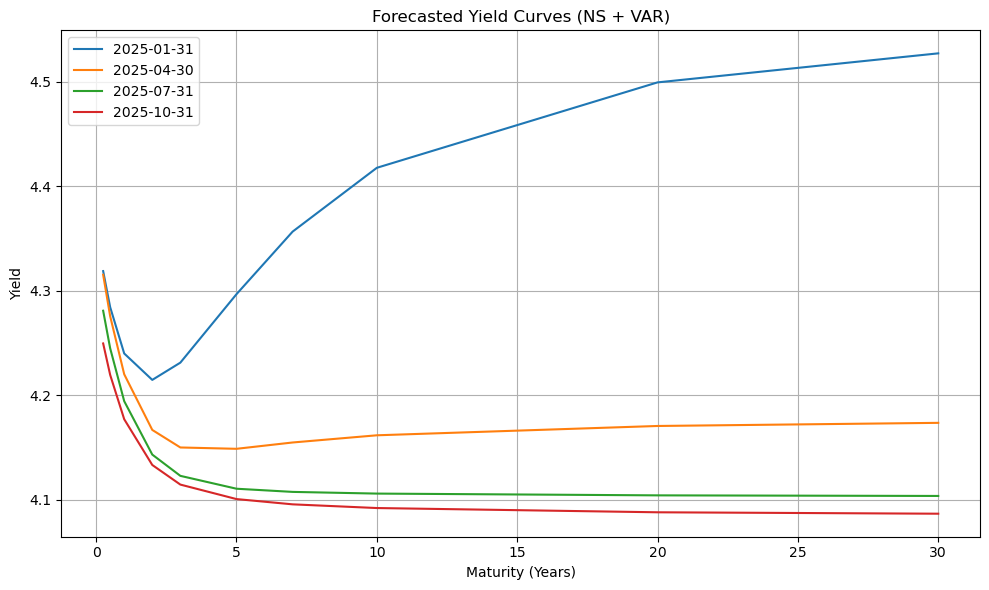

In [12]:
def nelson_siegel(tau, beta0, beta1, beta2, lamb):
    term1 = beta0
    term2 = beta1 * ((1 - np.exp(-lamb * tau)) / (lamb * tau))
    term3 = beta2 * (((1 - np.exp(-lamb * tau)) / (lamb * tau)) - np.exp(-lamb * tau))
    return term1 + term2 + term3

# standard maturities
maturities = np.array([0.25, 0.5, 1, 2, 3, 5, 7, 10, 20, 30])

# reconstruct forecasted yield curves
forecasted_curves = []
for date, row in forecast_df.iterrows():
    beta0, beta1, beta2, lamb = row
    yields = nelson_siegel(maturities, beta0, beta1, beta2, lamb)
    forecasted_curves.append(yields)

forecasted_yield_df = pd.DataFrame(forecasted_curves, index = forecast_df.index, columns = maturities)

plt.figure(figsize = (10, 6))
for date in forecasted_yield_df.index[::3]:  # plot every 3 months
    plt.plot(maturities, forecasted_yield_df.loc[date], label = str(date.date()))
plt.title("Forecasted Yield Curves (NS + VAR)")
plt.xlabel("Maturity (Years)")
plt.ylabel("Yield")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [10]:
forecasted_yield_df.head()

,0.25,0.50,1.00,2.00,3.00,5.00,7.00,10.00,20.00,30.00
2025-01-31,4.298631,4.263883,4.219982,4.197056,4.216503,4.286998,4.350156,4.414041,4.499165,4.528074
2025-02-28,4.298591,4.260197,4.209224,4.170953,4.173077,4.208437,4.242247,4.275593,4.318585,4.333067
2025-03-31,4.293256,4.253048,4.197970,4.149392,4.139576,4.152028,4.168229,4.184522,4.205314,4.212297
2025-04-30,4.285474,4.244838,4.188071,4.133582,4.116279,4.114523,4.120295,4.126911,4.135490,4.138371
2025-05-31,4.276810,4.236717,4.179991,4.122779,4.101092,4.090725,4.090294,4.091300,4.092926,4.093477


In [13]:
forecasted_yield_df.to_csv('results/forecasted_yield.csv')

New maturity periods: Maturities for every 0.5Y (from 0.5 to 30Y)

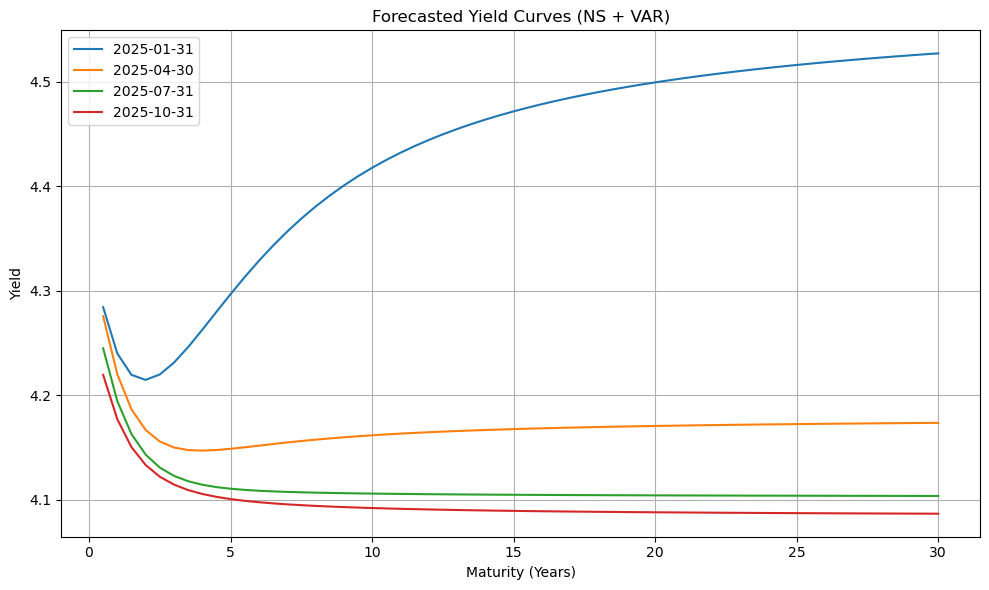

In [14]:
def nelson_siegel(tau, beta0, beta1, beta2, lamb):
    term1 = beta0
    term2 = beta1 * ((1 - np.exp(-lamb * tau)) / (lamb * tau))
    term3 = beta2 * (((1 - np.exp(-lamb * tau)) / (lamb * tau)) - np.exp(-lamb * tau))
    return term1 + term2 + term3

# 0.5 maturities
maturities = np.arange(0.5, 30.5, 0.5)

# reconstruct forecasted yield curves
forecasted_curves = []
for date, row in forecast_df.iterrows():
    beta0, beta1, beta2, lamb = row
    yields = nelson_siegel(maturities, beta0, beta1, beta2, lamb)
    forecasted_curves.append(yields)

forecasted_yield_df = pd.DataFrame(forecasted_curves, index = forecast_df.index, columns = maturities)

plt.figure(figsize = (10, 6))
for date in forecasted_yield_df.index[::3]:  # plot every 3 months
    plt.plot(maturities, forecasted_yield_df.loc[date], label = str(date.date()))
plt.title("Forecasted Yield Curves (NS + VAR)")
plt.xlabel("Maturity (Years)")
plt.ylabel("Yield")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [15]:
forecasted_yield_df.head()

,0.5,1.0,1.5,2.0,2.5,3.0,3.5,4.0,4.5,5.0,...,25.5,26.0,26.5,27.0,27.5,28.0,28.5,29.0,29.5,30.0
2025-01-31,4.284134,4.239850,4.219380,4.214566,4.219759,4.231083,4.245906,4.262468,4.279612,4.296600,...,4.517277,4.518535,4.519745,4.520910,4.522033,4.523116,4.524160,4.525169,4.526144,4.527086
2025-02-28,4.289024,4.237939,4.210202,4.197494,4.194258,4.196806,4.202715,4.210416,4.218906,4.227563,...,4.338431,4.339044,4.339634,4.340202,4.340749,4.341277,4.341787,4.342278,4.342753,4.343213
2025-03-31,4.284347,4.229781,4.197922,4.180507,4.172148,4.169355,4.169884,4.172304,4.175715,4.179562,...,4.233466,4.233763,4.234050,4.234325,4.234591,4.234847,4.235094,4.235333,4.235563,4.235786
2025-04-30,4.275483,4.219959,4.186401,4.166683,4.155615,4.149892,4.147421,4.146880,4.147448,4.148614,...,4.172404,4.172540,4.172670,4.172796,4.172917,4.173034,4.173146,4.173255,4.173360,4.173462
2025-05-31,4.265166,4.210391,4.176733,4.156268,4.144014,4.136847,4.132808,4.130677,4.129694,4.129387,...,4.136915,4.136965,4.137012,4.137058,4.137102,4.137145,4.137186,4.137226,4.137264,4.137301


In [16]:
forecasted_yield_df.to_csv('results/forecasted_yield_halfyear_mat.csv')

# Step 3.

## maturity time 15

### 1 year

In [ ]:
df_all = pd.read_csv('3 bond return prediction/15 .csv')
df_all['date'] = pd.to_datetime(df_all['date'])
df_all['mid_price'] = (df_all['bid'] + df_all['ask']) / 2

df_all['credit spread'] = df_all['credit spread'] / 10000

predict_horizon = 12


results = []

for bond_name, df in df_all.groupby('Name'):
    df = df.sort_values('date').reset_index(drop=True)
    df['future_mid_price'] = df['mid_price'].shift(-predict_horizon)
    df['future_annual_return'] = (df['future_mid_price'] / df['mid_price']) ** (12 / predict_horizon) - 1
    df = df.dropna(subset=['future_annual_return'])

    features = ['bid', 'ask', 'credit spread', 'yield', 'bid-ask', 'GDP', 'CPIAUCSL', 'UNRATE', 'PCE']
    X = df[features]
    y = df['future_annual_return']


    if len(df) < 24:
        continue

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    model = XGBRegressor(n_estimators=100, max_depth=3, learning_rate=0.1, random_state=42)
    model.fit(X_train, y_train)

    last_data = df[features].iloc[-1].values.reshape(1, -1)
    future_return_pred = model.predict(last_data)[0]

    results.append({
        'Bond Name': bond_name,
        'Predicted Annual Return (next 12 months)': f"{future_return_pred:.4%}"
    })

for r in results:
    print(f"{r['Bond Name']}: {r['Predicted Annual Return (next 12 months)']}")


US29364WBA53 ISIN: 1.7366%
US3130AE4K36 ISIN: 1.8477%
US3130AEJQ42 ISIN: 1.5927%
US3133EJR438 ISIN: -4.6032%
US3133EJW545 ISIN: -5.1527%
XS1451090192 ISIN: 4.6530%
XS1451093709 ISIN: 3.9706%
XS1451122573 ISIN: 3.5771%


### 3 year

In [ ]:
predict_horizon = 36

results = []

for bond_name, df in df_all.groupby('Name'):
    df = df.sort_values('date').reset_index(drop=True)
    df['future_mid_price'] = df['mid_price'].shift(-predict_horizon)
    df['future_annual_return'] = (df['future_mid_price'] / df['mid_price']) ** (12 / predict_horizon) - 1
    df = df.dropna(subset=['future_annual_return'])

    features = ['bid', 'ask', 'credit spread', 'yield', 'bid-ask', 'GDP', 'CPIAUCSL', 'UNRATE', 'PCE']
    X = df[features]
    y = df['future_annual_return']

    if len(df) < 24:
        continue

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    model = XGBRegressor(n_estimators=100, max_depth=3, learning_rate=0.1, random_state=42)
    model.fit(X_train, y_train)

    last_data = df[features].iloc[-1].values.reshape(1, -1)
    future_return_pred = model.predict(last_data)[0]

    results.append({
        'Bond Name': bond_name,
        'Predicted Annual Return (next 12 months)': f"{future_return_pred:.4%}"
    })
for r in results:
    print(f"{r['Bond Name']}: {r['Predicted Annual Return (next 12 months)']}")

US29364WBA53 ISIN: -7.8251%
US3130AE4K36 ISIN: -2.0123%
US3130AEJQ42 ISIN: -1.7022%
US3133EJR438 ISIN: -9.3475%
US3133EJW545 ISIN: -8.8584%
XS1451090192 ISIN: -5.5244%
XS1451093709 ISIN: -6.0829%
XS1451122573 ISIN: -8.2800%


### 4 year

In [ ]:
predict_horizon = 48

results = []

for bond_name, df in df_all.groupby('Name'):
    df = df.sort_values('date').reset_index(drop=True)
    df['future_mid_price'] = df['mid_price'].shift(-predict_horizon)
    df['future_annual_return'] = (df['future_mid_price'] / df['mid_price']) ** (12 / predict_horizon) - 1
    df = df.dropna(subset=['future_annual_return'])

    features = ['bid', 'ask', 'credit spread', 'yield', 'bid-ask', 'GDP', 'CPIAUCSL', 'UNRATE', 'PCE']
    X = df[features]
    y = df['future_annual_return']

    if len(df) < 24:
        continue

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    model = XGBRegressor(n_estimators=100, max_depth=3, learning_rate=0.1, random_state=42)
    model.fit(X_train, y_train)

    last_data = df[features].iloc[-1].values.reshape(1, -1)
    future_return_pred = model.predict(last_data)[0]

    results.append({
        'Bond Name': bond_name,
        f'Predicted Annual Return (next {predict_horizon} months)': f"{future_return_pred:.4%}"
    })

for r in results:
    bond = r['Bond Name']
    val = list(r.values())[1]
    print(f"{bond}: {val}")

US29364WBA53 ISIN: -6.2605%
US3130AE4K36 ISIN: -4.2759%
US3130AEJQ42 ISIN: -4.2250%
US3133EJR438 ISIN: -6.3407%
US3133EJW545 ISIN: -6.1206%
XS1451090192 ISIN: -2.8635%
XS1451093709 ISIN: -4.3343%
XS1451122573 ISIN: -6.2739%


## maturity time 10

### 1 year

In [ ]:
df_all = pd.read_csv('3 bond return prediction/10 .csv')
df_all['date'] = pd.to_datetime(df_all['date'])
df_all['mid_price'] = (pd.to_numeric(df_all['bid'], errors='coerce') + pd.to_numeric(df_all['ask'], errors='coerce')) / 2

df_all['credit spread'] = pd.to_numeric(df_all['credit spread'], errors='coerce') / 10000

predict_horizon = 12

results = []

for bond_name, df in df_all.groupby('name'):
    df = df.sort_values('date').reset_index(drop=True)
    df['future_mid_price'] = df['mid_price'].shift(-predict_horizon)
    df['future_annual_return'] = (df['future_mid_price'] / df['mid_price']) ** (12 / predict_horizon) - 1
    df = df.dropna(subset=['future_annual_return'])

    features = ['bid', 'ask', 'credit spread', 'yield', 'bid-ask', 'GDP', 'CPIAUCSL', 'UNRATE', 'PCE']
    for col in features:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    X = df[features]
    y = df['future_annual_return']

    if len(df) < 24:
        continue

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    model = XGBRegressor(n_estimators=100, max_depth=3, learning_rate=0.1, random_state=42)
    model.fit(X_train, y_train)

    last_data = df[features].iloc[-1].values.reshape(1, -1)
    future_return_pred = model.predict(last_data)[0]

    results.append({
        'Bond Name': str(bond_name),
        'Predicted Annual Return (next ' + str(predict_horizon) + ' months)': f"{future_return_pred:.4%}"
    })

for r in results:
    bond = str(r['Bond Name'])
    val = list(r.values())[1]
    print(f"{bond}: {val}")


AU3CB0250652 ISIN: -6.7614%
US06406RAH03 ISIN: 6.6689%
US29364DAV29 ISIN: -1.3278%
US3130AFFX04 ISIN: 0.8786%
US369550BC16 ISIN: 1.4922%
US377372AN70 ISIN: -0.3205%
US437076BW12 ISIN: -5.3285%
US64110LAT35 ISIN: -10.0025%
US91159HHS22 ISIN: -2.0899%
XS1748803282 ISIN: -1.9145%


### 3 year

In [ ]:
predict_horizon = 36

results = []

for bond_name, df in df_all.groupby('name'):
    df = df.sort_values('date').reset_index(drop=True)
    df['future_mid_price'] = df['mid_price'].shift(-predict_horizon)
    df['future_annual_return'] = (df['future_mid_price'] / df['mid_price']) ** (12 / predict_horizon) - 1
    df = df.dropna(subset=['future_annual_return'])

    features = ['bid', 'ask', 'credit spread', 'yield', 'bid-ask', 'GDP', 'CPIAUCSL', 'UNRATE', 'PCE']
    for col in features:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    X = df[features]
    y = df['future_annual_return']

    if len(df) < 24:
        continue

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    model = XGBRegressor(n_estimators=100, max_depth=3, learning_rate=0.1, random_state=42)
    model.fit(X_train, y_train)

    last_data = df[features].iloc[-1].values.reshape(1, -1)
    future_return_pred = model.predict(last_data)[0]

    results.append({
        'Bond Name': str(bond_name),
        'Predicted Annual Return (next ' + str(predict_horizon) + ' months)': f"{future_return_pred:.4%}"
    })

for r in results:
    bond = str(r['Bond Name'])
    val = list(r.values())[1]
    print(f"{bond}: {val}")

AU3CB0250652 ISIN: -1.1394%
US06406RAH03 ISIN: -5.0092%
US29364DAV29 ISIN: -4.9242%
US3130AFFX04 ISIN: -5.8416%
US369550BC16 ISIN: -4.7842%
US377372AN70 ISIN: -5.2165%
US437076BW12 ISIN: -5.2292%
US64110LAT35 ISIN: -5.0472%
US91159HHS22 ISIN: -5.4968%
XS1748803282 ISIN: -1.4205%


## maturity time 7

### 1 year

In [ ]:
df_all = pd.read_csv('3 bond return prediction/7.csv')
df_all['date'] = pd.to_datetime(df_all['date'])
df_all['mid_price'] = (pd.to_numeric(df_all['bid'], errors='coerce') + pd.to_numeric(df_all['ask'], errors='coerce')) / 2

df_all['credit spread'] = pd.to_numeric(df_all['credit spread'], errors='coerce') / 10000

predict_horizon = 12

results = []


for bond_name, df in df_all.groupby('name'):
    df = df.sort_values('date').reset_index(drop=True)
    df['future_mid_price'] = df['mid_price'].shift(-predict_horizon)
    df['future_annual_return'] = (df['future_mid_price'] / df['mid_price']) ** (12 / predict_horizon) - 1
    df = df.dropna(subset=['future_annual_return'])


    features = ['bid', 'ask', 'credit spread', 'yield', 'bid-ask', 'GDP', 'CPIAUCSL', 'UNRATE', 'PCE']
    for col in features:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    X = df[features]
    y = df['future_annual_return']


    if len(df) < 24:
        continue

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    model = XGBRegressor(n_estimators=100, max_depth=3, learning_rate=0.1, random_state=42)
    model.fit(X_train, y_train)

    last_data = df[features].iloc[-1].values.reshape(1, -1)
    future_return_pred = model.predict(last_data)[0]

    results.append({
        'Bond Name': str(bond_name),
        'Predicted Annual Return (next ' + str(predict_horizon) + ' months)': f"{future_return_pred:.4%}"
    })

for r in results:
    bond = str(r['Bond Name'])
    val = list(r.values())[1]
    print(f"{bond}: {val}")

US06654DAF42 ISIN: 2.0441%
US09247XAS09  ISIN: -0.6789%
US09261BAD29 ISIN: -4.3178%
US191216DP21 ISIN: -2.9236%
US29364WBH07 ISIN: -0.6622%
US46647PBX33 ISIN: 0.8218%
US46647PCC86 ISIN: 0.2345%
US46647PCR55 ISIN: -1.4113%
US72014TAC36 ISIN: -1.9123%
XS2296204444 ISIN: 1.6801%


## maturity time 5

### one year

In [ ]:
df_all = pd.read_csv('3 bond return prediction/5.csv') 
df_all['date'] = pd.to_datetime(df_all['date'])
df_all['mid_price'] = (pd.to_numeric(df_all['bid'], errors='coerce') + pd.to_numeric(df_all['ask'], errors='coerce')) / 2

df_all['credit spread'] = pd.to_numeric(df_all['credit spread'], errors='coerce') / 10000


predict_horizon = 12

results = []


for bond_name, df in df_all.groupby('name'):
    df = df.sort_values('date').reset_index(drop=True)
    df['future_mid_price'] = df['mid_price'].shift(-predict_horizon)
    df['future_annual_return'] = (df['future_mid_price'] / df['mid_price']) ** (12 / predict_horizon) - 1
    df = df.dropna(subset=['future_annual_return'])

    features = ['bid', 'ask', 'credit spread', 'yield', 'bid-ask', 'GDP', 'CPIAUCSL', 'UNRATE', 'PCE']
    for col in features:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    X = df[features]
    y = df['future_annual_return']

    if len(df) < 24:
        continue

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    model = XGBRegressor(n_estimators=100, max_depth=3, learning_rate=0.1, random_state=42)
    model.fit(X_train, y_train)

    last_data = df[features].iloc[-1].values.reshape(1, -1)
    future_return_pred = model.predict(last_data)[0]

    results.append({
        'Bond Name': str(bond_name),
        'Predicted Annual Return (next ' + str(predict_horizon) + ' months)': f"{future_return_pred:.4%}"
    })

for r in results:
    bond = str(r['Bond Name'])
    val = list(r.values())[1]
    print(f"{bond}: {val}")

US3130AKM522 ISIN: -1.6856%
US3130ALEJ96 ISIN: -1.4906%
US3133EM6A50 ISIN: -0.7193%
US48128G3D03 ISIN: 2.3605%
US668103AA24 ISIN: -4.4231%
XS2339398971 ISIN: 2.3738%
XS2384697830 ISIN: -2.2488%


### two year

In [ ]:
predict_horizon = 24

results = []

for bond_name, df in df_all.groupby('name'):
    df = df.sort_values('date').reset_index(drop=True)
    df['future_mid_price'] = df['mid_price'].shift(-predict_horizon)
    df['future_annual_return'] = (df['future_mid_price'] / df['mid_price']) ** (12 / predict_horizon) - 1
    df = df.dropna(subset=['future_annual_return'])

    features = ['bid', 'ask', 'credit spread', 'yield', 'bid-ask', 'GDP', 'CPIAUCSL', 'UNRATE', 'PCE']
    for col in features:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    X = df[features]
    y = df['future_annual_return']

    if len(df) < 24:
        continue

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    model = XGBRegressor(n_estimators=100, max_depth=3, learning_rate=0.1, random_state=42)
    model.fit(X_train, y_train)

    last_data = df[features].iloc[-1].values.reshape(1, -1)
    future_return_pred = model.predict(last_data)[0]

    results.append({
        'Bond Name': str(bond_name),
        'Predicted Annual Return (next ' + str(predict_horizon) + ' months)': f"{future_return_pred:.4%}"
    })

for r in results:
    bond = str(r['Bond Name'])
    val = list(r.values())[1]
    print(f"{bond}: {val}")

US3130AKM522 ISIN: -1.1114%
US668103AA24 ISIN: -1.1739%


## maturity time 3

### one year

In [ ]:
df_all = pd.read_csv('3 bond return prediction/3 .csv') 
df_all['date'] = pd.to_datetime(df_all['date'])
df_all['mid_price'] = (pd.to_numeric(df_all['bid'], errors='coerce') + pd.to_numeric(df_all['ask'], errors='coerce')) / 2

df_all['credit spread'] = pd.to_numeric(df_all['credit spread'], errors='coerce') / 10000

predict_horizon = 6

results = []

for bond_name, df in df_all.groupby('name'):
    df = df.sort_values('date').reset_index(drop=True)
    df['future_mid_price'] = df['mid_price'].shift(-predict_horizon)
    df['future_annual_return'] = (df['future_mid_price'] / df['mid_price']) ** (12 / predict_horizon) - 1
    df = df.dropna(subset=['future_annual_return'])

    features = ['bid', 'ask', 'credit spread', 'yield', 'bid-ask', 'GDP', 'CPIAUCSL', 'UNRATE', 'PCE']
    for col in features:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    X = df[features]
    y = df['future_annual_return']

    if len(df) < 24:
        continue

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    model = XGBRegressor(n_estimators=100, max_depth=3, learning_rate=0.1, random_state=42)
    model.fit(X_train, y_train)

    last_data = df[features].iloc[-1].values.reshape(1, -1)
    future_return_pred = model.predict(last_data)[0]

    results.append({
        'Bond Name': str(bond_name),
        'Predicted Annual Return (next ' + str(predict_horizon) + ' months)': f"{future_return_pred:.4%}"
    })

for r in results:
    bond = str(r['Bond Name'])
    val = list(r.values())[1]
    print(f"{bond}: {val}")

# Step 4.1 Bond Portfolio Optimization with Duration & Convexity

In [ ]:
data_path = '4 portfolio optimization/summary of bonds.xlsx'
bonds = pd.read_excel(data_path)

yield_curve = pd.read_excel('4 portfolio optimization/forecasted_yield_rate_standardized.xlsx')

In [ ]:
def calculate_duration_convexity(face_value, coupon_rate, maturity, freq, yield_curve):
    periods = int(np.round(maturity * freq))
    coupon = face_value * coupon_rate / freq

    times = np.array(range(1, periods + 1)) / freq
    cashflows = np.full(periods, coupon)
    cashflows[-1] += face_value

    discount_factors = []
    for t in times:
        closest = yield_curve.iloc[(yield_curve['Maturity'] - t).abs().argsort()[:1]]
        ytm_t = closest['Yield'].values[0] / 100
        discount_factor = 1 / (1 + ytm_t) ** t
        discount_factors.append(discount_factor)

    discount_factors = np.array(discount_factors)
    pv_cashflows = cashflows * discount_factors

    macaulay_duration = np.sum(times * pv_cashflows) / np.sum(pv_cashflows)
    convexity = np.sum(pv_cashflows * times * (times + 1/freq)) / (np.sum(pv_cashflows) * (1 + np.mean(yield_curve['Yield']/100))**2)

    return macaulay_duration, convexity

In [ ]:
bond_durations = []
bond_convexities = []

for i, row in bonds.iterrows():
    face_value = 100
    coupon_rate = row['coupon rate']
    maturity = row['remaining maturity']
    freq = row['cpn freq']

    duration, convexity = calculate_duration_convexity(face_value, coupon_rate, maturity, freq, yield_curve)

    bond_durations.append(duration)
    bond_convexities.append(convexity)

bond_durations = np.array(bond_durations)
bond_convexities = np.array(bond_convexities)

In [ ]:
target_duration = 5
lambda_convexity = 0.01
def objective(weights):
    portfolio_duration = np.dot(weights, bond_durations)
    portfolio_convexity = np.dot(weights, bond_convexities)
    return (portfolio_duration - target_duration) ** 2 - lambda_convexity * portfolio_convexity

def constraint_sum(weights):
    return np.sum(weights) - 1

bounds = [(0, 1)] * len(bond_durations)
initial_weights = np.array([1/len(bond_durations)] * len(bond_durations))
constraints = ({'type': 'eq', 'fun': constraint_sum})

In [ ]:
result = minimize(objective, initial_weights, method='SLSQP', bounds=bounds, constraints=constraints)

optimal_weights = result.x
final_duration = np.dot(optimal_weights, bond_durations)
final_convexity = np.dot(optimal_weights, bond_convexities)

In [ ]:
print("\n Optimal weights of bonds:")
for i, w in enumerate(optimal_weights):
    print(f"bond {bonds.iloc[i]['ISIN']}: weight {w:.4f}")

print(f"\n Duration of Portfolio: {final_duration:.4f} years")
print(f"Convexity of Portfolio: {final_convexity:.4f}")

In [ ]:
price_data = pd.read_excel('4 portfolio optimization/price_data2.xlsx') 
price_data = price_data.set_index(price_data.columns[0])

bond_ids = bonds['ISIN'].tolist()
price_data = price_data[bond_ids]

daily_portfolio_value = (price_data * optimal_weights).sum(axis=1)

portfolio_returns = daily_portfolio_value.pct_change().dropna()

annualized_return = (1 + portfolio_returns.mean()) ** 12 - 1
annualized_volatility = portfolio_returns.std() * np.sqrt(12)
sharpe_ratio = annualized_return / annualized_volatility

print(f"\n annualized return: {annualized_return:.4%}")
print(f" annualized volatility: {annualized_volatility:.4%}")
print(f" sharp ratio: {sharpe_ratio:.4f}")

cumulative_returns = (1 + portfolio_returns).cumprod()

plt.figure(figsize=(10,6))
plt.plot(cumulative_returns, label='Portfolio Cumulative Return')
plt.title('Backtest Portfolio Cumulative Return')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.show()


scenarios = [-0.01, -0.005, 0, 0.005, 0.01]  
print("\n Interest Rate Sensitivity Analysis:")
for delta_y in scenarios:
    price_change = -final_duration * delta_y + 0.5 * final_convexity * (delta_y ** 2)
    print(f"Interest change {delta_y*10000:.1f}bps: price change {price_change*100:.4f}%")

# Step 4.2 Bond Portfolio Optimization with VaR, ES, and MVO

In [ ]:
price_df = pd.read_excel('4 portfolio optimization/price_data2.xlsx', index_col=0)
summary_df = pd.read_excel('4 portfolio optimization/summary of bonds.xlsx')
returns = price_df.pct_change().dropna()

conf_level = 0.95
alpha = 1 - conf_level
initial_capital = 100

weights_record = []
portfolio_value = [initial_capital]
dates = returns.index

for i in range(3, len(dates)):
    past_returns = returns.iloc[i-3:i]

    mu = past_returns.mean()
    cov = past_returns.cov()
    n = len(mu)
    w = cp.Variable(n)

    portfolio_return = mu.values @ w
    portfolio_risk = cp.quad_form(w, cov.values)
    objective = cp.Maximize(portfolio_return - 0.5 * portfolio_risk)

    constraints = [
        cp.sum(w) == 1,
        w >= 0 
    ]

    prob = cp.Problem(objective, constraints)
    prob.solve()

    opt_w = w.value
    weights_record.append(opt_w)

    current_return = returns.iloc[i] @ opt_w
    new_value = portfolio_value[-1] * (1 + current_return)
    portfolio_value.append(new_value)
weights_df = pd.DataFrame(weights_record, index=dates[3:], columns=returns.columns)
portfolio_value_df = pd.DataFrame({'Portfolio Value': portfolio_value[1:]}, index=dates[3:])
latest_returns = returns.iloc[-3:]
VaR_95 = latest_returns.quantile(alpha)
ES_95 = latest_returns[latest_returns.le(VaR_95)].mean()

VaR_ES_summary = pd.DataFrame({
    'VaR_95': VaR_95,
    'Expected Shortfall_95': ES_95
})

with pd.ExcelWriter('results/portfolio_result.xlsx') as writer:
    weights_df.to_excel(writer, sheet_name='Weights')
    portfolio_value_df.to_excel(writer, sheet_name='Portfolio Value')
    VaR_ES_summary.to_excel(writer, sheet_name='VaR_ES Summary')

print("portfolio_result.xlsx")

portfolio_result.xlsx


In [ ]:
latest_returns = returns.iloc[-3:]
cov = latest_returns.cov()
mu = latest_returns.mean()

final_weight = weights_record[-1]

portfolio_mu = final_weight @ mu.values

portfolio_sigma = np.sqrt(final_weight @ cov.values @ final_weight)

VaR_95_combination = -(portfolio_mu + norm.ppf(alpha) * portfolio_sigma)
ES_95_combination = -(portfolio_mu + (norm.pdf(norm.ppf(alpha)) / alpha) * portfolio_sigma)

print(f"VaR (95%) = {VaR_95_combination:.4f}")
print(f"Expected Shortfall (95%) = {ES_95_combination:.4f}")

VaR (95%) = 0.0412
Expected Shortfall (95%) = -0.0557


## Interest Rate Shock Analysis

In [ ]:

summary_df = pd.read_excel('4 portfolio optimization/summary of bonds.xlsx')
last_prices = price_df.iloc[-1]
final_weights = np.array(weights_record[-1])
ytm = 0.05
def calculate_duration_convexity(maturity, coupon_rate, freq, price, ytm):
    periods = int(maturity * freq)
    coupon = coupon_rate / freq
    ytm_per_period = ytm / freq

    cashflows = np.array([coupon] * (periods - 1) + [1 + coupon])
    times = np.arange(1, periods + 1)

    discount_factors = (1 + ytm_per_period) ** (-times)
    pv_cashflows = cashflows * discount_factors

    macaulay_duration = np.sum(times * pv_cashflows) / np.sum(pv_cashflows)
    modified_duration = macaulay_duration / (1 + ytm_per_period)
    convexity = np.sum(times * (times + 1) * pv_cashflows) / (np.sum(pv_cashflows) * (1 + ytm_per_period)**2)

    return modified_duration, convexity
durations = []
convexities = []

for i in range(len(summary_df)):
    maturity = summary_df.loc[i, 'remaining maturity']
    coupon_rate = summary_df.loc[i, 'coupon rate']
    freq = summary_df.loc[i, 'cpn freq']
    isin = summary_df.loc[i, 'ISIN']
    
    if isin in last_prices.index:
        price = last_prices[isin]
        duration, convexity = calculate_duration_convexity(maturity, coupon_rate, freq, price, ytm)
        durations.append(duration)
        convexities.append(convexity)
    else:
        durations.append(np.nan)
        convexities.append(np.nan)
durations = np.array(durations)
convexities = np.array(convexities)
portfolio_duration = np.nansum(final_weights * durations)
portfolio_convexity = np.nansum(final_weights * convexities)

print(f"Portfolio Weighted Modified Duration: {portfolio_duration:.4f}")
print(f"Portfolio Weighted Convexity: {portfolio_convexity:.4f}")
scenarios = {
    "Interest Rate +50bp": 0.005,
    "Interest Rate +100bp": 0.010,
    "Interest Rate -50bp": -0.005,
    "Interest Rate -100bp": -0.010
}

print("\nInterest Rate Shock Analysis:")
for name, delta_y in scenarios.items():
    price_change = -portfolio_duration * delta_y + 0.5 * portfolio_convexity * (delta_y)**2
    print(f"{name}: Expected Portfolio Change = {price_change*100:.2f}%")

Portfolio Weighted Modified Duration: 7.0944
Portfolio Weighted Convexity: 59.3820

Interest Rate Shock Analysis:
Interest Rate +50bp: Expected Portfolio Change = -3.47%
Interest Rate +100bp: Expected Portfolio Change = -6.80%
Interest Rate -50bp: Expected Portfolio Change = 3.62%
Interest Rate -100bp: Expected Portfolio Change = 7.39%


## backtesting for section 4.2

Final Cumulative Return: 8.47%
Annualized Return: 11.45%
Annualized Volatility: 7.68%
Sharpe Ratio: 1.49


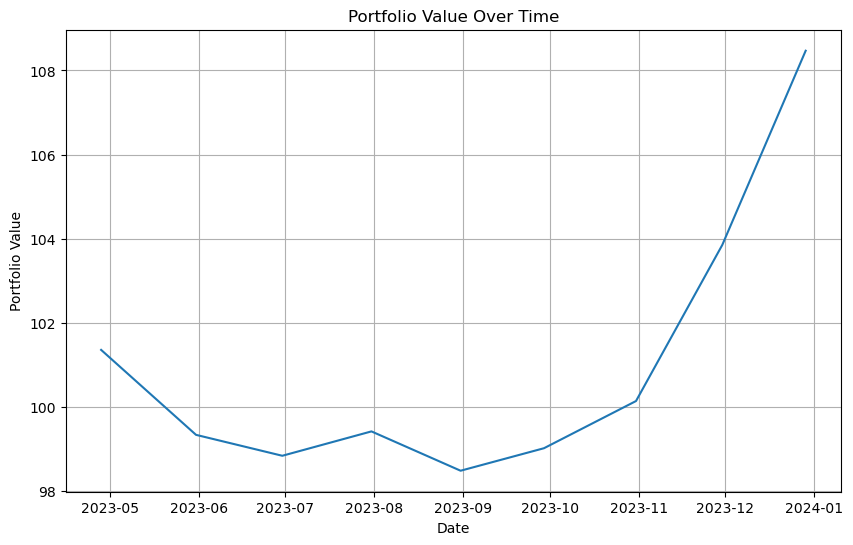

In [ ]:
returns = price_df.pct_change().dropna()
returns = returns.loc['2023-01-01':'2024-01-01']
initial_capital = 100
conf_level = 0.95
alpha = 1 - conf_level
portfolio_value = [initial_capital]
portfolio_weights = []
dates = returns.index

for i in range(3, len(dates)):
    past_returns = returns.iloc[i-3:i]
    
    mu = past_returns.mean()
    cov = past_returns.cov()
    n = len(mu)
    w = cp.Variable(n)
    portfolio_return = mu.values @ w
    portfolio_risk = cp.quad_form(w, cov.values)
    objective = cp.Maximize(portfolio_return - 0.5 * portfolio_risk)
    
    constraints = [cp.sum(w) == 1, w >= 0]
    prob = cp.Problem(objective, constraints)
    prob.solve()
    opt_w = w.value
    portfolio_weights.append(opt_w)
    current_return = returns.iloc[i] @ opt_w
    new_value = portfolio_value[-1] * (1 + current_return)
    portfolio_value.append(new_value)

portfolio_value = pd.Series(portfolio_value[1:], index=dates[3:])
portfolio_returns = portfolio_value.pct_change().dropna()

cumulative_return = (portfolio_value.iloc[-1] / initial_capital - 1) * 100
annualized_return = ((portfolio_value.iloc[-1] / initial_capital) ** (12/len(portfolio_value)) - 1) * 100
annualized_volatility = portfolio_returns.std() * np.sqrt(12) * 100
sharpe_ratio = (annualized_return - 0) / annualized_volatility 

print(f"Final Cumulative Return: {cumulative_return:.2f}%")
print(f"Annualized Return: {annualized_return:.2f}%")
print(f"Annualized Volatility: {annualized_volatility:.2f}%")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")

plt.figure(figsize=(10,6))
plt.plot(portfolio_value)
plt.title('Portfolio Value Over Time')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.grid(True)
plt.show()
